#### Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2022-11-15 23:29:56.840206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 23:29:56.953191: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-15 23:29:56.956726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 23:29:56.956737: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

#### Static variables

In [2]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
VOCAB_SIZE = 1000
EPOCHS = 15
OUTPUT_DIM = 64

#### Gather the data

In [3]:
# gather the data
neutral_csv = "/home/madhu/Documents/practice/machine_learning/twitter_classification/processedNeutral.csv"
positive_csv = "/home/madhu/Documents/practice/machine_learning/twitter_classification/processedPositive.csv"
negative_csv = "/home/madhu/Documents/practice/machine_learning/twitter_classification/processedNegative.csv"

In [4]:
neutral_df = pd.read_csv(neutral_csv)
negative_df = pd.read_csv(negative_csv)
positive_df = pd.read_csv(positive_csv)

In [5]:
neutral_df = pd.DataFrame(np.vstack(neutral_df.columns), columns=['tweets'])
negative_df = pd.DataFrame(np.vstack(negative_df.columns), columns=['tweets'])
positive_df = pd.DataFrame(np.vstack(positive_df.columns), columns=['tweets'])

In [6]:
# currently lets deal with only two label data
negative_df["sentiment"] = 0
positive_df["sentiment"] = 1

In [7]:
ds = positive_df.append(negative_df)

/tmp/ipykernel_15001/3669637914.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = positive_df.append(negative_df)


In [8]:
ds.head()

,tweets,sentiment
0,An inspiration in all aspects: Fashion,1
1,fitness,1
2,beauty and personality. :)KISSES TheFashionIcon,1
3,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,1
4,Beautiful album from the greatest unsung guit...,1


In [9]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 1116
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweets     2303 non-null   object
 1   sentiment  2303 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 54.0+ KB


#### Split datasets

In [10]:
index = np.random.rand(len(ds)) < 0.8
train = ds[index]
test = ds[~index]

train_ds = tf.data.Dataset.from_tensor_slices((train['tweets'], train['sentiment']))
test_ds = tf.data.Dataset.from_tensor_slices((test['tweets'], test['sentiment']))

2022-11-15 23:29:59.015884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:29:59.016289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 23:29:59.016316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-15 23:29:59.016338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-15 23:29:59.016358: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

#### Separate by batch wise

In [11]:
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
for s,l in train_ds.take(1):
    print(s.numpy()[:2],l.numpy()[:2])

[b'there are some rumors going around and videos of his performances on youtube have already been deleted.. '
 b'did some warm up sketches of some of my faves'] [0 0]


#### Text Encoder

In [13]:
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda samples, labels:samples))

In [14]:
encoder.get_vocabulary()[:10]

['', '[UNK]', 'unhappy', 'happy', 'to', 'i', 'the', 'a', 'for', 'you']

#### Create the model

In [15]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim = len(encoder.get_vocabulary()), output_dim=OUTPUT_DIM, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64)
        ),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ]
)

#### Sample Test

In [16]:
# sample test 
sample = ""
label = ""
for s, l in test_ds.take(1):
    sample = s.numpy()[25]
    label = l.numpy()[25]
print(sample)
print(label)

b"Ministers of PMLN are happy like those students who never studied for exams  luckily exams got delayed. They'll still ha.1"
1


In [17]:
prediction = model.predict(np.array([sample]))

1/1 [==============================] - 1s 1s/step


In [18]:
prediction

array([[0.0130673]], dtype=float32)

In [19]:
padding = "the " * 2000
predictions = model.predict(np.array([sample, padding]))
print(predictions[0])

1/1 [==============================] - 0s 86ms/step
[0.0130673]


#### Compile Model

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#### Train the model

In [21]:
history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=test_ds)

Epoch 1/15
29/29 [==============================] - 5s 53ms/step - loss: 0.6919 - accuracy: 0.4833 - val_loss: 0.6900 - val_accuracy: 0.4916
Epoch 2/15
29/29 [==============================] - 0s 13ms/step - loss: 0.6871 - accuracy: 0.4833 - val_loss: 0.6835 - val_accuracy: 0.4916
Epoch 3/15
29/29 [==============================] - 0s 14ms/step - loss: 0.6781 - accuracy: 0.4833 - val_loss: 0.6719 - val_accuracy: 0.4916
Epoch 4/15
29/29 [==============================] - 0s 16ms/step - loss: 0.6615 - accuracy: 0.4833 - val_loss: 0.6504 - val_accuracy: 0.4916
Epoch 5/15
29/29 [==============================] - 0s 14ms/step - loss: 0.6283 - accuracy: 0.5244 - val_loss: 0.6062 - val_accuracy: 0.5861
Epoch 6/15
29/29 [==============================] - 0s 14ms/step - loss: 0.5601 - accuracy: 0.6984 - val_loss: 0.5188 - val_accuracy: 0.7710
Epoch 7/15
29/29 [==============================] - 0s 14ms/step - loss: 0.4428 - accuracy: 0.8555 - val_loss: 0.4053 - val_accuracy: 0.8592
Epoch 8/15
29

In [22]:
history.history

{'loss': [0.691932737827301,
  0.6870637536048889,
  0.6781153678894043,
  0.6614992618560791,
  0.6283063888549805,
  0.560124397277832,
  0.44278988242149353,
  0.3205260932445526,
  0.24459145963191986,
  0.2035743147134781,
  0.17760545015335083,
  0.15735790133476257,
  0.14253740012645721,
  0.13024628162384033,
  0.1258625090122223],
 'accuracy': [0.483305960893631,
  0.483305960893631,
  0.483305960893631,
  0.483305960893631,
  0.5243568420410156,
  0.6984127163887024,
  0.8555008172988892,
  0.9031198620796204,
  0.9277504086494446,
  0.9365079402923584,
  0.9408866763114929,
  0.9469075202941895,
  0.9529283046722412,
  0.954023003578186,
  0.9534756541252136],
 'val_loss': [0.6900032758712769,
  0.683498740196228,
  0.671909511089325,
  0.6504247188568115,
  0.6062164902687073,
  0.5188047289848328,
  0.4053388237953186,
  0.344120591878891,
  0.3227241635322571,
  0.3084007799625397,
  0.31003984808921814,
  0.3375418186187744,
  0.34556975960731506,
  0.35353419184684753,

In [23]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 0s 4ms/step - loss: 0.3374 - accuracy: 0.8845
Test Loss: 0.3373633921146393
Test Accuracy: 0.8844537734985352


In [24]:
# sample prediction
sample = ""
label = ""
for s, l in test_ds.take(1):
    sample = s.numpy()[25]
    label = l.numpy()[25]
print(sample)
print(label)
prediction = model.predict(np.array([sample]))
prediction

b"Ministers of PMLN are happy like those students who never studied for exams  luckily exams got delayed. They'll still ha.1"
1
1/1 [==============================] - 1s 1s/step


array([[11.28436]], dtype=float32)

(0.0, 0.720236249268055)

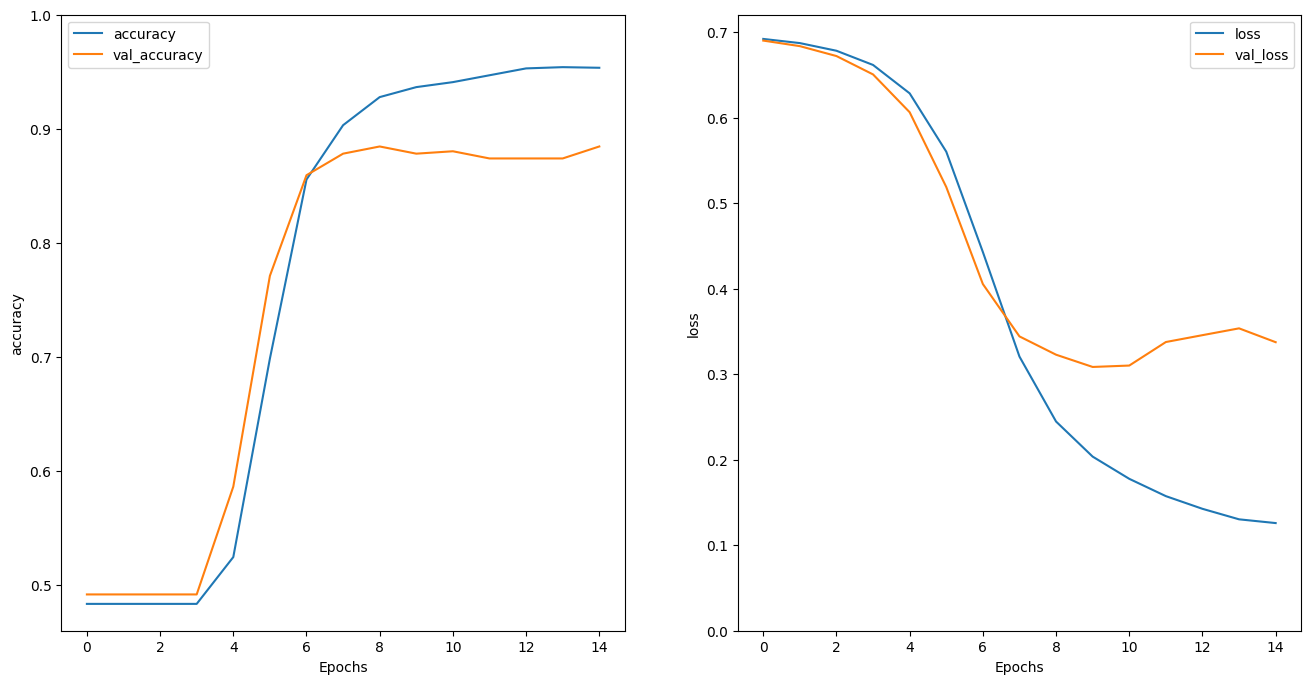

In [25]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)